# Algo de pacing complet (meta class)

L'objectif est de réimplémenter l'algo de Pacing complet à l'aide d'une méta class qui gère elle même ses instances selon les dimensions dans lesquelles on veut répartir le budget.
L'idée est de rentrer un dictionnaire de clés qui contient les dimensions du Pacing et on associe une instance à chaque clé. 

### Pacing class

In [1]:
from datetime import datetime
from datetime import timedelta
import pandas as pd
import pytz
import itertools
from statsmodels.formula.api import ols
from loguru import logger
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [2]:
class Pacing:
    """ The pacing algorithm class
    """
    def __init__(self, total_budget, start_date, end_date, timezone):
        """Class constructor"""
        # Raise errors in parameters
        if total_budget < 0:
            raise ValueError("Budget cannot be negative!")
        if start_date > end_date:
            raise ValueError("Start date cannot be later than end date!")

        # Fixed attributes
        self.tz = pytz.timezone(timezone)
        self.start_date = self.tz.localize(start_date)
        self.end_date = self.tz.localize(end_date)
        self.total_days = (self.end_date - self.start_date).days + 1
        self.building = list()
        # Impossible day and hour to initialize the setup
        self.day = 0
        self.total_budget = total_budget
        self.remaining_budget = self.total_budget
        self.engaged_budget = 0
        self.spent_budget = 0
        
    def gen_prop_lr(self, br_object):
        """Linear regression with hours and weekdays"""
        aggr = br_object.imps.groupby([br_object.index.date, br_object.index.weekday, br_object.index.hour]).sum()
        aggr.index.names = ['date', 'weekday', 'hour']
        aggr = aggr.reset_index()
        model = ols('imps ~ C(weekday) + C(hour)', data=aggr).fit()
        weekday_list = range(7)
        weekday_list = list(itertools.chain.from_iterable(itertools.repeat(x, 24) for x in weekday_list))
        hour_list = list()
        for i in range(7):
            for z in range(24):
                hour_list.append(z)
        df_fitting = pd.DataFrame({'weekday': weekday_list, 'hour': hour_list})
        prediction = model.predict(df_fitting)
        df_fitting['fitted'] = prediction
        pattern = df_fitting.pivot_table('fitted', index=df_fitting.hour, columns=df_fitting.weekday)
        line, col = pattern.shape
        for i in range(col):
            pattern.iloc[:, i] = pattern.iloc[:, i] * 100 / pattern.iloc[:, i].sum()
        return pattern
    
    def gen_prop_lr_hour(self, br_object):
        """Linear regression with only hours"""
        aggr = br_object.imps.groupby([br_object.index.date, br_object.index.hour]).sum().reset_index()
        aggr.columns = ['date', 'hour', 'imps']
        model = ols('imps ~ C(hour)', data=aggr).fit()
        hour_list = list()
        for z in range(24):
            hour_list.append(z)
        df_fitting = pd.DataFrame({'hour': hour_list})
        prediction = model.predict(df_fitting)
        df_fitting['fitted'] = prediction
        df_fitting.index = df_fitting.hour
        del df_fitting['hour']
        df_fitting.iloc[:, 0] = df_fitting.iloc[:, 0] * 100 / df_fitting.iloc[:, 0].sum()
        return df_fitting

    def meta_prop(self, data):
        """ Give the proportion of impressions per hour. The output type depends on the input.

        :param data: a dataframe with a datetime as index
        :return: an  integer, a Serie or a Dataframe
        """
        if data.empty:
            unif = True
            without_weekday = True
            prop = 1/24
        elif set(data.index.hour.unique()) != set(range(24)):
            unif = True
            without_weekday = True
            prop = 1/24
        else:
            if set(data.index.weekday.unique()) != set(range(7)):
                unif = False
                without_weekday = True
                prop = self.gen_prop_lr_hour(data)
            else:
                unif = False
                without_weekday = False
                prop = self.gen_prop_lr(data)
        return prop, unif, without_weekday

    def day_reset(self, ts):
        """ Reset variables when there is a new day
        """
        day = ts.day
        month = ts.month
        year = ts.year
        remaining_days = (self.end_date - ts).days + 2   # +2 because biased calculation of days
        if not self.building:
            self.building_data = pd.DataFrame.from_records(self.building)
        else:
            self.building_data = pd.DataFrame.from_records(self.building, index='Date')
        self.current_hour = -1
        self.remaining_budget_hour = 0
        self.daily_budget = self.remaining_budget / remaining_days
        self.surplus_hour = 0
        self.BT = [0]
        self.acceleration = [{'ts': self.tz.localize(datetime(year, month, day, 0, 0, 0)),
                              'A': 0}]
        self.speed = [{'ts': self.tz.localize(datetime(year, month, day, 0, 0, 0)),
                       'S': 0}]
        self.size_acceleration = 1
        self.sum_acceleration = 0
        self.size_speed = 1
        self.sum_speed = 0
        self.prop_table, self.unif, self.without_weekday = self.meta_prop(self.building_data)

    def hour_reset(self, weekday):
        """ Reset budget for the following hour
        """
        self.current_hour += 1
        self.remaining_hours = 24 - self.current_hour
        # Evolutive target
        self.surplus_hour += self.remaining_budget_hour / self.remaining_hours
        if self.unif:
            self.budget_hour = (self.prop_table * self.daily_budget) + self.surplus_hour
        elif self.without_weekday and not self.unif:
            self.budget_hour = (self.prop_table.iloc[
                                    self.current_hour, 0] / 100) * self.daily_budget + self.surplus_hour
        else:
            self.budget_hour = (self.prop_table.iloc[
                                    self.current_hour, weekday] / 100) * self.daily_budget + self.surplus_hour
        self.target = self.budget_hour / 3600
        self.spent_hour = 0
        self.remaining_budget_hour = self.budget_hour - self.spent_hour

    def gen_mean(self, mean_type):
        """ Return the average variation and speed of variation for bt
        """
        created_time = self.acceleration[-1]['ts'] - timedelta(minutes=30)
        if mean_type == 'acceleration':
            while self.acceleration[0]['ts'] < created_time:
                self.size_acceleration -= 1
                self.sum_acceleration += self.acceleration[0]['A']
                del self.acceleration[0]
            try:
                average = self.sum_acceleration / self.size_acceleration
            except ZeroDivisionError:
                average = 0
        else:
            while self.speed[0]['ts'] < created_time:
                self.size_speed -= 1
                self.sum_speed += self.speed[0]['S']
                del self.speed[0]
            try:
                average = self.sum_speed / self.size_speed
            except ZeroDivisionError:
                average = 0
        return average

    def build_data_prop(self, ts, imps):
        self.building.append({'Date': ts, 'imps': imps})

    def bt_calculation(self, average_acceleration, average_speed, remaining_time, coef=1):
        """ Return the per second budget
        """
        alpha = average_acceleration * coef
        try:
            bt = self.remaining_budget_hour * ((1 + alpha * average_speed) / remaining_time)
        except ZeroDivisionError:
            bt = 1
        if bt < 0:
            bt = 1
        return bt

    def buying_decision(self, ts, price, imps):
        """From a BR, decide whether to buy or not

        :param ts: timestamp of the BR
        :param price: price of the BR
        :param imps: number of impressions
        :return: Boolean
        """

        # Check problem in br
        if price < 0:
            return False
        if imps < 0:
            return False

        # TS de la BR
        weekday = ts.weekday()
        day = ts.day
        month = ts.month
        year = ts.year
        hour = ts.hour

        # If we begin a new day, we reset variables
        if self.day != day:
            self.day_reset(ts)
        self.day = day

        # Changement of hour
        while hour != self.current_hour:
            self.hour_reset(weekday)

        # Build data for proportion lr
        self.build_data_prop(ts, imps)

        # Remaining time before the end of the hour
        end_hour = self.tz.localize(datetime(year, month, day, hour, 59, 59, 999999))
        remaining_time = datetime.timestamp(end_hour)+10 - datetime.timestamp(ts)

        # Calculation of bt
        average_acceleration = self.gen_mean('acceleration')
        average_speed = self.gen_mean('speed')
        self.bt = self.bt_calculation(average_acceleration, average_speed, remaining_time)

        # Calculation of vt and at
        self.BT.append(self.bt)
        vt = self.BT[-1] - self.BT[-2]
        self.speed.append({'ts': ts,
                           'S': vt})
        self.size_speed += 1
        at = self.speed[-1]['S'] - self.speed[-2]['S']
        self.acceleration.append({'ts': ts,
                                  'A': at})
        self.size_acceleration += 1

        # Buying decision
        if (self.bt >= self.target) and (self.remaining_budget_hour - price) >= 0:
            buying = True
            self.engaged_budget += price
            self.spent_hour += price
        else:
            buying = False
        self.remaining_budget_hour = self.budget_hour - self.spent_hour
        self.remaining_budget = self.total_budget - (self.engaged_budget + self.spent_budget)

        return buying

    def receive_notification(self, status, br_price):
        """ From a notification, take into account the status (win/lose)
        """
        if status == 'win':
            self.engaged_budget -= br_price
            self.spent_budget += br_price
        elif status == 'lose':
            self.engaged_budget -= br_price
            self.spent_hour -= br_price
        self.remaining_budget = self.total_budget - (self.engaged_budget + self.spent_budget)

In [3]:
def send_pending_notifications(instance_obj, pending_notif, current_ts=None):
    """ Send notifications

    :param instance_obj: instance of the algorithm class
    :param pending_notif: list of notifications
    :param current_ts: if None: will send all notifications, else send before current_ts
    """
    while len(pending_notif) > 0 and (pending_notif[0]['timestamp'] <= current_ts if current_ts else True):
        ev = pending_notif.pop(0)
        instance_obj.dispatch_notifications(ev['id'], ev['status'], ev['br_price'])

### Meta class

In [4]:
class GlobalPacing(object):
    def __init__(self, total_budget, start_date, end_date, tz_list, prop_tz):
        self.total_budget = total_budget
        self.start_date = start_date
        self.end_date = end_date
        self.tz_list = tz_list
        self.prop_tz = prop_tz
        self.timezones = {}
        
        # Budget repartition
        self.Budget_tz = self.prop_tz * self.total_budget
        
        # Instance creation
        self.instances = {}
        for key in self.tz_list:
            self.instances[key] = Pacing(total_budget=self.Budget_tz[key], 
                                         start_date=self.start_date, 
                                         end_date=self.end_date, timezone=key)
    def choose_pacing(self, ts, tz, price, imps, br_id):
        local_date = datetime.fromtimestamp(ts, tz=pytz.timezone(tz))
        buying = self.instances[tz].buying_decision(local_date, price, imps)
        if buying:
            self.timezones[br_id] = tz
        remaining_budget = self.instances[tz].remaining_budget
        spent_budget = self.instances[tz].spent_budget
        engaged_budget = self.instances[tz].engaged_budget
        return buying, remaining_budget, spent_budget, engaged_budget
    
    def dispatch_notifications(self, br_id, status, br_price):
        tz = self.timezones[br_id]
        del self.timezones[br_id]
        self.instances[tz].receive_notification(status, br_price)
    
    def pacing_performance(self):
        remainings = {}
        spents = {}
        for key in self.tz_list:
            remainings[key] = self.instances[key].remaining_budget
            spents[key] = self.instances[key].spent_budget
        return remainings, spents

In [17]:
def main(data, budget, day_start, day_end):
    logger.info(f"Start pacing on {len(data)} bid requests")
    tz_list = data.TZ.unique().tolist()
    prop_tz = (data.groupby(data['TZ']).size()/len(data))
    pacing = GlobalPacing(total_budget=budget, start_date=datetime(2020,7,day_start), 
                    end_date=datetime(2020,7,day_end), tz_list=tz_list, prop_tz=prop_tz)
    records = []
    pending_notifications = []
    for utc, row in data.iterrows():
        tz = row['TZ']
        ts = row['ts']
        local = datetime.fromtimestamp(ts, tz=pytz.timezone(tz))
        
        # Before the campaign?
        if local < pytz.timezone(tz).localize(pacing.start_date):
            continue
            
        # End of the campaign?
        if local > pytz.timezone(tz).localize(pacing.end_date + timedelta(days=1)):
            continue
            
        # Send current notifications
        send_pending_notifications(pacing, pending_notifications, utc)
    
        # Receive BR and make a decision
        buying, remaining_budget, spent_budget, engaged_budget = pacing.choose_pacing(
            ts, tz, row['price'], row['imps'], row['id'])

        # Create notification
        if buying:
            next_notif_ts = utc + timedelta(seconds=row['seconds_notif'])
            status = "win" if row['win'] else "lose"
            br_id = row['id']
            pending_notifications.append(
                {"timestamp": next_notif_ts, "status": status, 
                 "br_price": row['price'], "id": br_id})
            pending_notifications.sort(key=lambda x: x["timestamp"])
        record = {
            'utc_date': utc,
            'local_date': local,
            'tz': tz,
            'buying': buying,
            'remaining': remaining_budget,
            'spent': spent_budget,
            'engaged': engaged_budget
        }
        records.append(record)
    # Send remaining notifications
    send_pending_notifications(pacing, pending_notifications)
    
    # Get pacing performances
    remainings, spents = pacing.pacing_performance()

    # Generate result DataFrame
    pacing_df = pd.DataFrame.from_records(records)
    pacing_df.set_index('utc_date', inplace=True)
    logger.info("End of the campaign")
    logger.info(f"Total budget spent: {sum(spents.values())}")
    logger.info(f"Remaining budget: {sum(remainings.values())}")
    return pacing_df

In [6]:
df = pd.read_pickle('br_clean.pkl')
df.set_index('UTC_date', inplace = True)
df.sort_index(inplace = True)

In [7]:
df['id'] = range(len(df))

In [8]:
df

,local_date,local_hour,ts,TZ,imps,CPM,price,win,seconds_notif,id
UTC_date,,,,,,,,,,
2020-07-08 00:00:00.042,2020-07-07 20:00:00.042000-04:00,20,1.594166e+09,America/New_York,25.037222,9,0.225335,True,4,0
2020-07-08 00:00:00.070,2020-07-07 20:00:00.070000-04:00,20,1.594166e+09,America/New_York,27.289524,9,0.245606,True,32,1
2020-07-08 00:00:00.235,2020-07-07 20:00:00.235000-04:00,20,1.594166e+09,America/Indiana/Indianapolis,14.187500,9,0.127688,True,42,2
2020-07-08 00:00:00.493,2020-07-07 19:00:00.493000-05:00,19,1.594166e+09,America/Chicago,2.755000,9,0.024795,True,6,3
2020-07-08 00:00:00.787,2020-07-08 02:00:00.787000+02:00,2,1.594166e+09,Europe/Paris,1.000000,6,0.006000,True,35,4
...,...,...,...,...,...,...,...,...,...,...
2020-07-15 03:10:10.286,2020-07-14 20:10:10.286000-07:00,20,1.594783e+09,America/Phoenix,2.581984,9,0.023238,True,8,5999995
2020-07-15 03:10:10.384,2020-07-14 22:10:10.384000-05:00,22,1.594783e+09,America/Chicago,1.570079,9,0.014131,True,11,5999996
2020-07-15 03:10:10.558,2020-07-14 23:10:10.558000-04:00,23,1.594783e+09,America/New_York,10.327063,9,0.092944,True,22,5999997


In [9]:
# data = df[df.TZ == 'America/New_York']
# databis = data['2020-07-08':'2020-07-10']
databis = df['2020-07-08':'2020-07-10']

In [10]:
databis

,local_date,local_hour,ts,TZ,imps,CPM,price,win,seconds_notif,id
UTC_date,,,,,,,,,,
2020-07-08 00:00:00.042,2020-07-07 20:00:00.042000-04:00,20,1.594166e+09,America/New_York,25.037222,9,0.225335,True,4,0
2020-07-08 00:00:00.070,2020-07-07 20:00:00.070000-04:00,20,1.594166e+09,America/New_York,27.289524,9,0.245606,True,32,1
2020-07-08 00:00:00.235,2020-07-07 20:00:00.235000-04:00,20,1.594166e+09,America/Indiana/Indianapolis,14.187500,9,0.127688,True,42,2
2020-07-08 00:00:00.493,2020-07-07 19:00:00.493000-05:00,19,1.594166e+09,America/Chicago,2.755000,9,0.024795,True,6,3
2020-07-08 00:00:00.787,2020-07-08 02:00:00.787000+02:00,2,1.594166e+09,Europe/Paris,1.000000,6,0.006000,True,35,4
...,...,...,...,...,...,...,...,...,...,...
2020-07-10 23:59:59.422,2020-07-10 16:59:59.422000-07:00,16,1.594426e+09,America/Phoenix,43.797556,9,0.394178,False,42,2504202
2020-07-10 23:59:59.507,2020-07-10 19:59:59.507000-04:00,19,1.594426e+09,America/New_York,2.438155,9,0.021943,True,51,2504203
2020-07-10 23:59:59.662,2020-07-10 18:59:59.662000-05:00,18,1.594426e+09,America/Chicago,30.932778,9,0.278395,True,54,2504204


In [11]:
%%time
pacing_results = main(databis, 5000, 8, 9)

2020-08-20 16:21:35.028 | INFO     | __main__:main:2 - Start pacing on 2504207 bid requests


0


2020-08-20 16:30:39.307 | INFO     | __main__:main:57 - End of the campaign
2020-08-20 16:30:39.307 | INFO     | __main__:main:58 - Total budget spent: 4998.991151604687
2020-08-20 16:30:39.308 | INFO     | __main__:main:59 - Remaining budget: 1.0088483953143896


CPU times: user 9min 4s, sys: 1.02 s, total: 9min 5s
Wall time: 9min 5s


In [15]:
pacing_results.groupby(pacing_results.tz).tail(1)

,local_date,tz,buying,remaining,spent,engaged
utc_date,,,,,,
2020-07-09 21:59:59.212,2020-07-09 23:59:59.212000+02:00,Europe/Paris,True,0.026469,342.996000,1.740000e-01
2020-07-09 22:59:59.086,2020-07-09 23:59:59.086000+01:00,Europe/London,False,0.021064,170.388000,1.020000e-01
2020-07-10 03:59:13.253,2020-07-09 23:59:13.253000-04:00,America/Kentucky/Louisville,False,0.112307,4.835367,0.000000e+00
2020-07-10 03:59:15.104,2020-07-09 23:59:15.104000-04:00,America/Indiana/Indianapolis,False,0.003725,16.218975,0.000000e+00
2020-07-10 03:59:53.800,2020-07-09 23:59:53.800000-04:00,America/Detroit,True,0.030733,98.430387,1.316667e-02
2020-07-10 03:59:59.139,2020-07-09 23:59:59.139000-04:00,America/New_York,False,0.100283,2050.586486,1.322110e+00
2020-07-10 04:59:59.508,2020-07-09 23:59:59.508000-05:00,America/Chicago,False,0.071801,1898.676598,6.852348e-01
2020-07-10 05:59:45.669,2020-07-09 23:59:45.669000-06:00,America/Boise,False,0.005842,23.246043,1.296429e-02
2020-07-10 05:59:51.783,2020-07-09 23:59:51.783000-06:00,America/Denver,False,0.002242,56.364903,1.942890e-16


In [16]:
sum(pacing_results.groupby(pacing_results.tz).tail(1).remaining)

0.39637006200276126

In [20]:
sum(pacing_results.groupby(pacing_results.tz).tail(1).spent)

4997.238127051056

/home/thomas/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


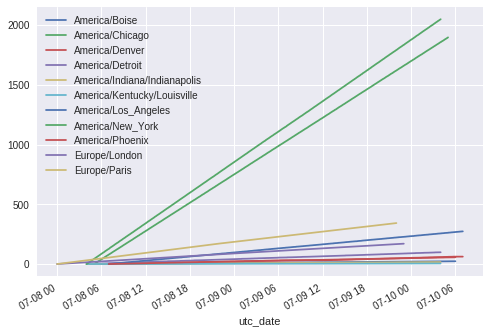

In [19]:
pacing_results.groupby(pacing_results.tz).spent.plot()
plt.legend()

### Calcul autonome de la proportion des tz

L'objectif est désormais d'inclure un calcul de la proportion d'impressions par tz qui soit géré par la meta class elle même.  